# Move distribution per piece

In [14]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
import seaborn as sns
sns.set_theme()

Connection to database

In [15]:
conn = sqlite3.connect("chess_games.db")
cursor = conn.cursor()

In [16]:
df = pd.read_sql_query("""
    SELECT game_id, move, move_number
    FROM moves
    WHERE game_id <= 20000
    ORDER BY game_id ASC, move_number ASC
""", conn)

In [17]:
df.head()

,game_id,move,move_number
0,1,d2d4,1
1,1,f7f5,2
2,1,g2g3,3
3,1,g7g6,4
4,1,f1g2,5


## Average Move Distribution per Piece Across All Games

In [18]:
# Initialize variables
piece_move_counter = Counter()
current_game_id = None
board = chess.Board()

for _, row in df.iterrows():
    game_id = row["game_id"]
    move_str = row["move"]
    # Reset board at the start of a new game
    if game_id != current_game_id:
        board = chess.Board()
        current_game_id = game_id
    try:
        move = board.parse_uci(move_str)
        piece = board.piece_at(move.from_square)
        if piece:
            piece_move_counter[piece.symbol().lower()] += 1
        board.push(move)
    except Exception as e:
        print(f"Game {game_id}, move {move_str} caused error: {e}")
        continue

piece_distribution = pd.DataFrame.from_dict(piece_move_counter, orient='index', columns=['count'])

piece_distribution["relative_frequency"] = piece_distribution["count"] / piece_distribution["count"].sum()

# Sort for clarity
piece_distribution = piece_distribution.sort_values(by="count", ascending=False)

# Print result
print(piece_distribution)

     count  relative_frequency
k  1017365            0.267414
r   835097            0.219505
p   622320            0.163576
b   548017            0.144046
n   431579            0.113440
q   350081            0.092019


plot the distribution per piece

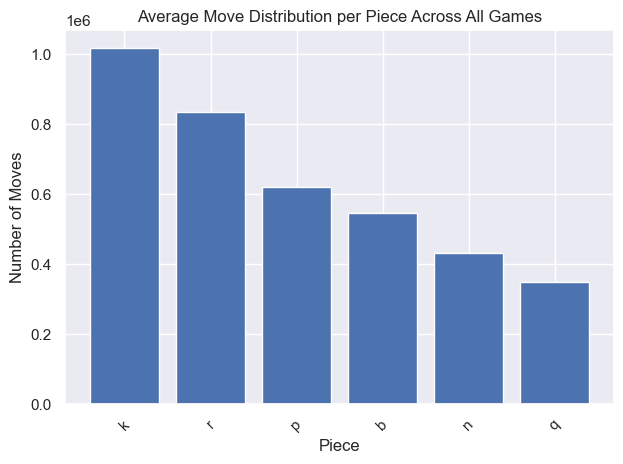

In [19]:
labels = piece_distribution.index
counts = piece_distribution["count"]

plt.bar(labels, counts)
plt.title("Average Move Distribution per Piece Across All Games")
plt.xlabel("Piece")
plt.ylabel("Number of Moves")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Move distribution per piece dividing the phases of the game

In [20]:
def classify_phase(move_number):
    if move_number <= 10:
        return 'opening'
    elif move_number <= 30:
        return 'midgame'
    else:
        return 'endgame'


In [23]:
phase_game_groups = df.groupby(["phase", "game_id"])["move"].apply(list)
phase_game_groups


phase    game_id
endgame  1          [c1d2, f6e4, g2e4, e7e6, d2g5, d8d6, a1d1, d6d...
         2          [a1e1, f6e6, h5f5, e5d3, e1e6, c8e6, f5d3, a8e...
         3          [b2b4, h7h5, e2h5, e6c4, a2a3, g7g6, a1c1, c4d...
         4          [a2b3, d7c5, b3b4, c5a4, c3d5, c8e6, b1b3, a4b...
         5          [e3e4, f6h5, f4e3, b6c7, c4a2, e7f6, f2f4, f6d...
                                          ...                        
opening  19996      [e2e4, e7e6, d2d4, d7d5, b1d2, c7c5, e4d5, e6d...
         19997      [e2e4, c7c5, b1c3, e7e6, f2f4, d7d5, g1f3, d5d...
         19998      [g1f3, g8f6, c2c4, g7g6, d2d4, f8g7, b1c3, d7d...
         19999      [e2e4, e7e5, g1f3, b8c6, f1c4, f8c5, c2c3, d7d...
         20000      [e2e4, c7c5, b1c3, e7e6, g1f3, d7d6, d2d4, c5d...
Name: move, Length: 59997, dtype: object

In [25]:
# Initialize variables
piece_move_counter = Counter()
current_game_id = None
board = chess.Board()

# average piece distribution per phase
phase_piece_distribution = {
    phase: Counter() for phase in ['opening', 'midgame', 'endgame']
}

for _, row in df.iterrows():
    game_id = row["game_id"]
    move_str = row["move"]
    move_number = row["move_number"]
    phase = row["phase"]
    
    # Reset board at the start of a new game
    if game_id != current_game_id:
        board = chess.Board()
        current_game_id = game_id
    try:
        move = board.parse_uci(move_str)
        piece = board.piece_at(move.from_square)
        if piece:
            piece_move_counter[piece.symbol().lower()] += 1
            phase_piece_distribution[phase][piece.symbol().lower()] += 1
        board.push(move)
    except Exception as e:
        print(f"Game {game_id}, move {move_str} caused error: {e}")
        continue


In [70]:
print("Phase-wise piece distribution:")
for phase, counter in phase_piece_distribution.items():
    print(f"\n{phase.capitalize()} phase:")
    phase_distribution = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    phase_distribution["relative_frequency"] = phase_distribution["count"] / phase_distribution["count"].sum()
    print(phase_distribution)

Phase-wise piece distribution:

Opening phase:
    count  relative_frequency
p  112473            0.562365
b   23510            0.117550
n   56138            0.280690
q    3599            0.017995
k    4129            0.020645
r     151            0.000755

Midgame phase:
    count  relative_frequency
p  125235            0.313106
n   88655            0.221650
q   43280            0.108206
k   31527            0.078822
b   86316            0.215802
r   24964            0.062414

Endgame phase:
    count  relative_frequency
b  438191            0.136743
n  286786            0.089495
q  303202            0.094618
r  809982            0.252765
p  384612            0.120023
k  981709            0.306355


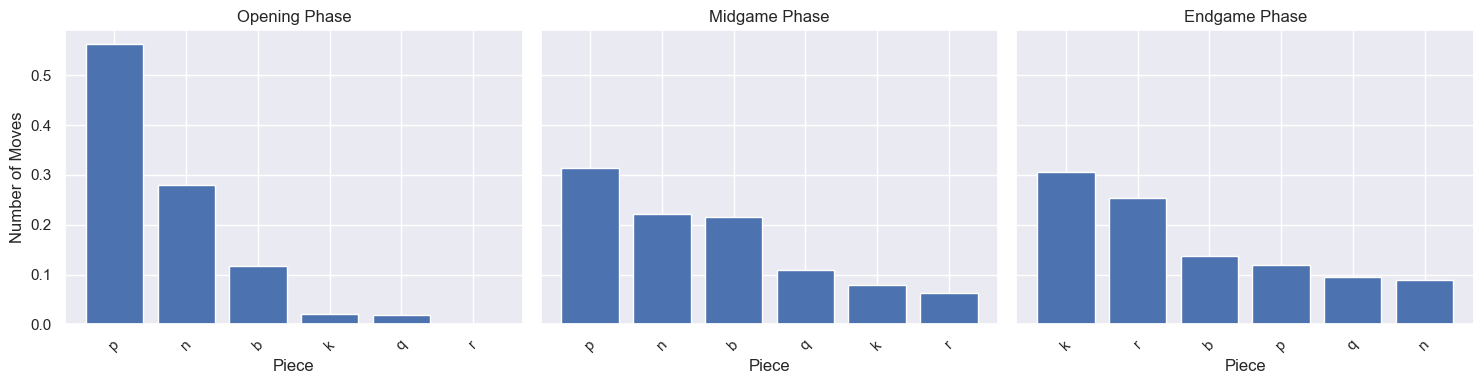

In [83]:
# Plotting phase-wise distributions as subplots
def plot_phase_distributions_subplots(phase_piece_distribution):
    phases = list(phase_piece_distribution.keys())
    num_phases = len(phases)    
    # Create subplots
    fig, axes = plt.subplots(1, num_phases, figsize=(5 * num_phases, 4), sharey=True)
    
    for i, (phase, counter) in enumerate(phase_piece_distribution.items()):
        phase_distribution = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
        phase_distribution = phase_distribution.sort_values(by="count", ascending=False)
        
        labels = phase_distribution.index
        counts = phase_distribution["count"]
        
        axes[i].bar(labels, counts)
        axes[i].set_title(f"{phase.capitalize()} Phase")
        axes[i].set_xlabel("Piece")
        axes[i].set_xticks(range(len(labels)))
        axes[i].set_xticklabels(labels, rotation=45)
        axes[i].set_ylabel("Number of Moves" if i == 0 else "")
    
    plt.tight_layout()
    plt.show()

plot_phase_distributions_subplots(phase_piece_distribution)

In [81]:
phase_piece_distribution

{'opening': Counter({'p': 0.562365,
          'n': 0.28069,
          'b': 0.11755,
          'k': 0.020645,
          'q': 0.017995,
          'r': 0.000755}),
 'midgame': Counter({'p': 0.31310550356645506,
          'n': 0.2216502448890811,
          'b': 0.2158024086384967,
          'q': 0.10820622185775682,
          'k': 0.07882203226685534,
          'r': 0.06241358878135493}),
 'endgame': Counter({'k': 0.306354974064451,
          'r': 0.25276534553790597,
          'b': 0.13674316160927102,
          'p': 0.12002314258591561,
          'q': 0.09461810052295504,
          'n': 0.0894952756795014})}

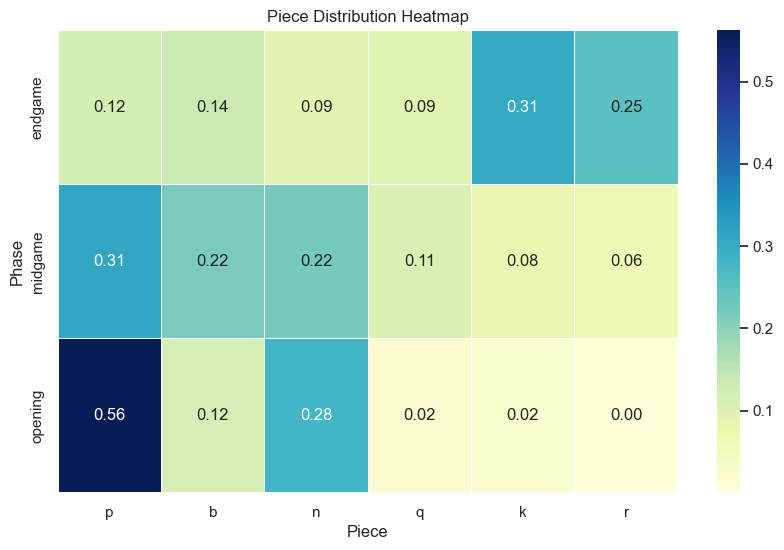

In [79]:
#heatmap of piece distribution
def plot_heatmap(phase_piece_distribution):
    #normalize the counts to get relative frequencies
    for phase in phase_piece_distribution:
        total_moves = sum(phase_piece_distribution[phase].values())
        for piece in phase_piece_distribution[phase]:
            phase_piece_distribution[phase][piece] /= total_moves
    # Create a DataFrame for the heatmap
    heatmap_data = pd.DataFrame.from_dict(phase_piece_distribution, orient='index').fillna(0)
    heatmap_data = heatmap_data.reindex(sorted(heatmap_data.index), axis=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, linewidths=.5)
    plt.title("Piece Distribution Heatmap")
    plt.xlabel("Piece")
    plt.ylabel("Phase")
    plt.show()
plot_heatmap(phase_piece_distribution)